# Data Assignment/ Table of contents

In [187]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import re
import string
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


## Data Importing

Census train and test data is imported.   Data is combined into one data set with a column to differentiate between train and test to be split later.

In [188]:
# Load Census Data
census_income_test = pd.read_csv('census_income_test.csv', header=None)
census_income_train = pd.read_csv('census_income_train.csv', header=None)

# Add train and test columns
census_income_test['split'] = 'test'
census_income_train['split'] = 'train'

# Combine Data
census_income = pd.concat([census_income_train,census_income_test], ignore_index=True)

# Info
census_income.head(5)
census_income.shape
census_income_train.shape
census_income_test.shape

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,split
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,train
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,train
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,train
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train


(299285, 43)

(199523, 43)

(99762, 43)

* Note data has 43 columns,  1 column is added for test/train, and one column is added for target (+-50,000)

In [189]:
#Load Meta Data

#Show lines of tables from meta document
table1_lines = [23,67]
table2_lines = [81,120] 

# Create tables to store Meta Data
table1 = pd.DataFrame(columns=['name','long_name_t1'])
table2 = pd.DataFrame(columns=['long_name_t2','num_uniq','type'])

# Read in tables
with open('census_income_metadata.txt',newline='') as f:
    r = csv.reader(f,delimiter='~')
    for line_number, line in enumerate(r):
        if line_number >= table1_lines[0] and line_number <= table1_lines[1]:
            p1 = re.compile('\W*([A-Za-zÀ-ȕ0-9(),-_., \']*)\W*(\w+)')
            m1 = p1.match(line[0])
            table1 = pd.concat([table1, pd.DataFrame.from_records([{ 'name': m1.group(2), 'long_name_t1': m1.group(1) }])], ignore_index=True)
            
        if line_number >= table2_lines[0] and line_number <= table2_lines[1]:
            p2 = re.compile('\W*(\d+).*\((.*)\)\s*(\w+)')
            m2 = p2.match(line[0])
            table2 = pd.concat([table2, pd.DataFrame.from_records([{ 'long_name_t2': m2.group(2), 'num_uniq': m2.group(1), 'type': m2.group(3) }])], ignore_index=True)
            


In [190]:
table1.shape
table2.shape

(45, 2)

(40, 3)

The first table has 45 features the 2nd has 40.  Our data has 41 features.   Reading the meta document the 2nd table is missing the instance weight feature.  1st table gives short names, 2nd table give number of unique values and type (continuous/nomnial).  Instyance weight will have to be added back in.  Noting that the data columns in alphabetical order.

The two table will be merged so that the short names and types can be associated with each other.  The long names are the only data to be matched on, but they are not exact matches, so fuzzy matching will be used.

In [191]:
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Function to join two data frams on an outer join,  the first dataframe key column being used as the main key
def fuzzy_join(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_1[key1].tolist()
    
    m = df_2[key2].apply(lambda x: process.extract(x, s, limit=limit))    
    df_2['matches'] = m
    
    m2 = df_2['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_2['matches'] = m2
    
    df_2.loc[df_2.duplicated(['matches']),'matches'] = pd.NA
   
    df_3 = df_1.merge(df_2,left_on=key1,right_on='matches',how='outer')

    df_3 = df_3.drop(columns=['matches'])
    
    return df_3
#Join Meta tables



In [192]:
meta_table = fuzzy_join(table1, table2, 'long_name_t1', 'long_name_t2',threshold=75, limit=1)
meta_table

,name,long_name_t1,long_name_t2,num_uniq,type
0,AAGE,age,age,91,continuous
1,ACLSWKR,class of worker,class of worker,9,nominal
2,ADTIND,industry code,detailed industry recode,52,nominal
3,ADTOCC,occupation code,detailed occupation recode,47,nominal
4,AGI,adjusted gross income,NaN,NaN,NaN
5,AHGA,education,education,17,nominal
6,AHRSPAY,wage per hour,wage per hour,1240,continuous
7,AHSCOL,enrolled in edu inst last wk,enroll in edu inst last wk,3,nominal
8,AMARITL,marital status,marital stat,7,nominal
9,AMJIND,major industry code,major industry code,24,nominal


Tables are verified matches.  Note that the year column does not have a short name, so one will be created.  Also, short naames without data information will be dropped as they are not in this data set.

In [193]:
# Create new clean table
meta_clean = meta_table[['name','num_uniq','type','long_name_t1']]

# Drop irrelavant rows
meta_clean = meta_clean.dropna(subset=['num_uniq'],)
meta_clean = meta_clean.reset_index(drop=True)

# Add YEAR short name
meta_clean.at[39,'name'] = 'YEAR'

# Add Instance weight,  Target, and Train/test split
# Adding Z to keep alphabetical
df_add = pd.DataFrame({'name' : ['INST','ZA_TARGET','ZZ_SPLIT'],'num_uniq' : [0,2,2],'type' : ['ignore','target','reference'], 'long_name_t1' : ['Instance Weight', 'Target +- 50k', 'Test or Train']})
meta_clean = pd.concat([meta_clean, df_add], ignore_index=True)
meta_clean.sort_values(by=['name'],inplace=True)

meta_clean.reset_index().drop(columns='index')
meta_clean[:20]
meta_clean[21:]

,name,num_uniq,type,long_name_t1
0,AAGE,91,continuous,age
1,ACLSWKR,9,nominal,class of worker
2,ADTIND,52,nominal,industry code
3,ADTOCC,47,nominal,occupation code
4,AHGA,17,nominal,education
5,AHRSPAY,1240,continuous,wage per hour
6,AHSCOL,3,nominal,enrolled in edu inst last wk
7,AMARITL,7,nominal,marital status
8,AMJIND,24,nominal,major industry code
9,AMJOCC,15,nominal,major occupation code


,name,num_uniq,type,long_name_t1
0,AAGE,91,continuous,age
1,ACLSWKR,9,nominal,class of worker
2,ADTIND,52,nominal,industry code
3,ADTOCC,47,nominal,occupation code
4,AHGA,17,nominal,education
5,AHRSPAY,1240,continuous,wage per hour
6,AHSCOL,3,nominal,enrolled in edu inst last wk
7,AMARITL,7,nominal,marital status
8,AMJIND,24,nominal,major industry code
9,AMJOCC,15,nominal,major occupation code


,name,num_uniq,type,long_name_t1
21,GRINST,51,nominal,state of previous residence
22,HHDFMX,38,nominal,detailed household and family stat
23,HHDREL,8,nominal,detailed household summary in household
40,INST,0,ignore,Instance Weight
24,MIGMTR1,10,nominal,migration code-change in msa
25,MIGMTR3,9,nominal,migration code-change in reg
26,MIGMTR4,10,nominal,migration code-move within reg
27,MIGSAME,3,nominal,live in this house 1 year ago
28,MIGSUN,4,nominal,migration prev res in sunbelt
29,NOEMP,7,continuous,num persons worked for employer


In [194]:
# Create list of column names from short name
names = meta_clean['name'].values.tolist()
names

['AAGE',
 'ACLSWKR',
 'ADTIND',
 'ADTOCC',
 'AHGA',
 'AHRSPAY',
 'AHSCOL',
 'AMARITL',
 'AMJIND',
 'AMJOCC',
 'ARACE',
 'AREORGN',
 'ASEX',
 'AUNMEM',
 'AUNTYPE',
 'AWKSTAT',
 'CAPGAIN',
 'CAPLOSS',
 'DIVVAL',
 'FILESTAT',
 'GRINREG',
 'GRINST',
 'HHDFMX',
 'HHDREL',
 'INST',
 'MIGMTR1',
 'MIGMTR3',
 'MIGMTR4',
 'MIGSAME',
 'MIGSUN',
 'NOEMP',
 'PARENT',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'SEOTR',
 'VETQVA',
 'VETYN',
 'WKSWORK',
 'YEAR',
 'ZA_TARGET',
 'ZZ_SPLIT']

In [195]:
# Assign short names to column heads for census data and verify
census_income.columns = names
census_income.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,ZA_TARGET,ZZ_SPLIT
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,train
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,train
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,train
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train


Convert Target +- 50000 to binary 1/0 where 1 is = 50000

In [196]:
# Convert Target to Binary
census_income['ZA_TARGET'] = census_income['ZA_TARGET'].apply(lambda x:1 if x == ' 50000+.' else 0)
census_income['ZA_TARGET'].astype('category', copy=False)

# Drop Instance Weight
census_income = census_income.drop(columns='INST')

census_income.info()

0         0
1         0
2         0
3         0
4         0
         ..
299280    0
299281    0
299282    0
299283    0
299284    0
Name: ZA_TARGET, Length: 299285, dtype: category
Categories (2, int64): [0, 1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299285 entries, 0 to 299284
Data columns (total 42 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   AAGE       299285 non-null  int64 
 1   ACLSWKR    299285 non-null  object
 2   ADTIND     299285 non-null  int64 
 3   ADTOCC     299285 non-null  int64 
 4   AHGA       299285 non-null  object
 5   AHRSPAY    299285 non-null  int64 
 6   AHSCOL     299285 non-null  object
 7   AMARITL    299285 non-null  object
 8   AMJIND     299285 non-null  object
 9   AMJOCC     299285 non-null  object
 10  ARACE      299285 non-null  object
 11  AREORGN    299285 non-null  object
 12  ASEX       299285 non-null  object
 13  AUNMEM     299285 non-null  object
 14  AUNTYPE    299285 non-null  object
 15  AWKSTAT    299285 non-null  object
 16  CAPGAIN    299285 non-null  int64 
 17  CAPLOSS    299285 non-null  int64 
 18  DIVVAL     299285 non-null  int64 
 19  FILESTAT   299285 non-null  object
 20  GRIN

Drop Instance Weight as per Instructions

Data is now imported with correct column names. Target has been split into a binary 1,0. 1 representing a salary of more and 50000, and 0 less than.
A meta table has also been built to keep descriptive names and record continuous/nominal and Instance weight is dropped as per instructions.

## Data Cleaning/Exploration

### 1 Remove Duplicates

In [197]:
raw_shape = census_income.shape

# find duplicated rows (keep first)
census_income_clean = census_income.drop_duplicates(keep='first')

new_shape = census_income_clean.shape

print(f'Number of instances: {raw_shape[0]}')
print(f'Number of duplicates: {raw_shape[0]-new_shape[0]}')
print(f'Number of instances updated: {new_shape[0]}')



Number of instances: 299285
Number of duplicates: 67525
Number of instances updated: 231760


67525 duplicates removed.

##  2 Target Data

In [198]:
# Count Target >50k versus <50k
target_counts = census_income_clean['ZA_TARGET'].value_counts()
target_porp  = target_counts[0]/(target_counts[0]+target_counts[1])
print(f'{target_porp} of records <50k')

0.9199473593372455 of records <50k


Data is heavily unbalanced with 94% of records showing under 50k

## 3 Numerical Features

In [199]:
# Function for graphing
def plot_hist(df,x,y,xlabel,ylabel,ylog = 0,title = 'none', figsize = (8,5)):
    # Plot histogram with target stacked)
    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(1,1,1)
    
    if title=='none':
        title = xlabel

    sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x=x, kde=False,
             palette="pastel", hue=y,
             element="bars", legend=True)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylog == 1:
        ax.set_yscale('log')
    ax.set_ylabel('count')

    ax.legend(('Salary > 50K', 'Salary < 50K'), fontsize=12);



In [200]:
# Num Features
meta_clean.loc[meta_clean['type'] == 'continuous']


,name,num_uniq,type,long_name_t1
0,AAGE,91,continuous,age
5,AHRSPAY,1240,continuous,wage per hour
16,CAPGAIN,132,continuous,capital gains
17,CAPLOSS,113,continuous,capital losses
18,DIVVAL,1478,continuous,divdends from stocks
29,NOEMP,7,continuous,num persons worked for employer
38,WKSWORK,53,continuous,weeks worked in year


### Summary Statistics
7 continuous numerical features. AHRSPAY (Wage per hour), CAPGAIN, CAPLOSS, and DIVAL are all highly skewed.  AHRSPAY, CAPGAIN and DIVAL all have ceiling of 9999

In [201]:
col_numerical = list(meta_clean.loc[meta_clean['type'] == 'continuous','name'])
census_income[col_numerical].agg(['mean','median','min','max','var','std','skew']).transpose()

,mean,median,min,max,var,std,skew
AAGE,34.538998,33.0,0.0,90.0,4.981140e+02,22.318468,0.372785
AHRSPAY,55.105027,0.0,0.0,9999.0,7.471515e+04,273.340729,8.878780
CAPGAIN,431.742176,0.0,0.0,99999.0,2.181608e+07,4670.768536,19.090569
CAPLOSS,36.849010,0.0,0.0,4608.0,7.278652e+04,269.789771,7.685924
DIVVAL,195.851259,0.0,0.0,99999.0,3.755251e+06,1937.847082,27.144287
NOEMP,1.956172,1.0,0.0,6.0,5.592548e+00,2.364857,0.752317
WKSWORK,23.178375,8.0,0.0,52.0,5.955560e+02,24.404016,0.210018


#### 3a - Age

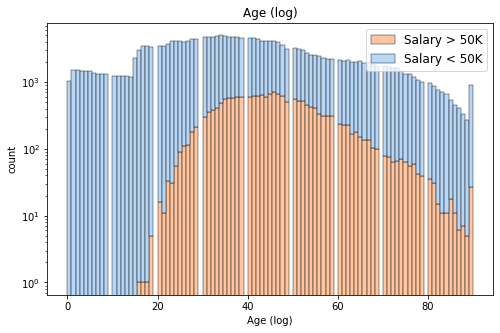

In [202]:
plot_hist(census_income_clean,'AAGE','ZA_TARGET','Age (log)','Salary',1)

In [203]:
# Find min age with postive 50k
min_age = census_income_clean.loc[census_income_clean['ZA_TARGET'] == 1,'AAGE'].min()
print(f'Min Age with 50k+ salary: {min_age}')

Min Age with 50k+ salary: 16


Age column seems reasonable.  90 years looks like a ceiling value.  Under 16 falls in line with not having a salary due to US work laws.  Those with Salary>50k peaks around 35-55.

#### 3b Wage per Hour (AHRSPAY)

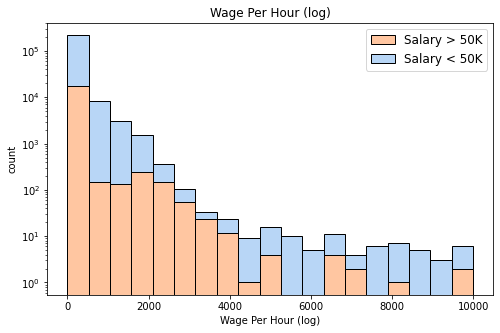

In [204]:
plot_hist(census_income_clean,'AHRSPAY','ZA_TARGET','Wage Per Hour (log)','Salary',1)

In [205]:
no_wage = census_income_clean['AHRSPAY'] == 0.0
min_wage = census_income_clean[census_income_clean['AHRSPAY'] > 0]['AHRSPAY'].min()
print(f'Number with No wage: {no_wage.sum()}')
print(f'Percent with No wage: {no_wage.sum()/no_wage.count()}')
print(f'Minimum wage: {min_wage}')

Number with No wage: 214874
Percent with No wage: 0.927140144977563
Minimum wage: 20


Wage per hour seems suspect.  Minimum wage is 20, which is very high for the mid 90's.  Also 94% of the data has 0 wages, which indicates many this might be missing data. 
Data does follow a distribution up to about 5000.  Over that the data seems incomplete.  Possibly at this level income may or may not come from Salary, but other sources.  May want consolidate values over 5000.

#### 3c CAPGAIN (Capital Gains)

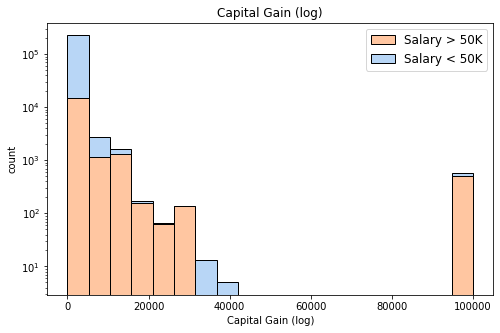

In [206]:
plot_hist(census_income_clean,'CAPGAIN','ZA_TARGET','Capital Gain (log)','Salary',1)

C:\Users\AMGra\AppData\Local\Temp\ipykernel_30472\642928659.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_hist(census_income_clean[census_income['CAPGAIN']==0],'CAPGAIN','ZA_TARGET','No Capital Gain','Salary',0)


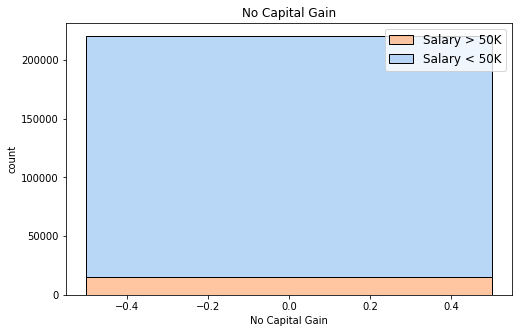

In [207]:
plot_hist(census_income_clean[census_income['CAPGAIN']==0],'CAPGAIN','ZA_TARGET','No Capital Gain','Salary',0)

In [208]:
no_capgain = census_income_clean['CAPGAIN'] == 0.0
num_max_capgain = census_income_clean[census_income_clean['CAPGAIN'] == census_income_clean['CAPGAIN'].max()]['CAPGAIN'].count()

print(f'Number with No Capital Gain: {no_capgain.sum()}')
print(f'Percent with No Capital Gain: {no_capgain.sum()/no_capgain.count()}')
print(f'Number of  Capital Gain: {num_max_capgain}')


Number with No Capital Gain: 220666
Percent with No Capital Gain: 0.9521315153607179
Number of  Capital Gain: 578


The amount of capital gain doesn't seem to be that correlated with salary, whether or not there is capital gains seems to have an effect.  Most records show No capital Gain.  May consider switching this to a binary Have/Have no capital Gains.


#### 3d CAPLOSS (Capital Loss)

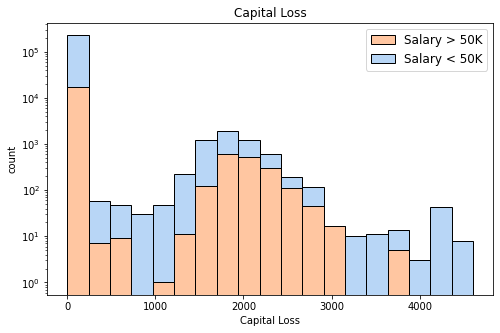

In [209]:
plot_hist(census_income_clean,'CAPLOSS','ZA_TARGET','Capital Loss','Salary',1)

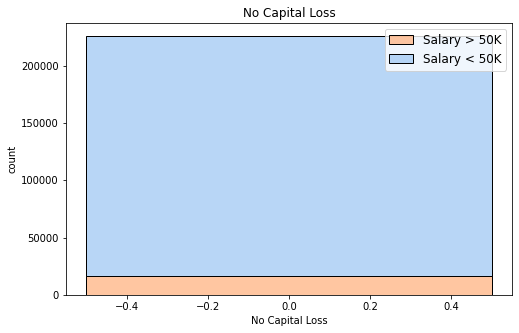

In [210]:
plot_hist(census_income_clean[census_income_clean['CAPLOSS']==0],'CAPLOSS','ZA_TARGET','No Capital Loss','Salary',0)

In [211]:
no_capgain = census_income_clean['CAPLOSS'] == 0.0
num_max_capgain = census_income_clean[census_income_clean['CAPLOSS'] == census_income_clean['CAPLOSS'].max()]['CAPGAIN'].count()

print(f'Number with No Capital Loss: {no_capgain.sum()}')
print(f'Percent with No Capital Loss: {no_capgain.sum()/no_capgain.count()}')
print(f'Number of  Capital Loss: {num_max_capgain}')

Number with No Capital Loss: 225947
Percent with No Capital Loss: 0.9749180186399724
Number of  Capital Loss: 8


As with Wage and Capital Gains,  most records show no loss.  There is no artifical ceiling. Possible binary candidate as well.

#### 3e DIVVAL (Dividends from Stocks)

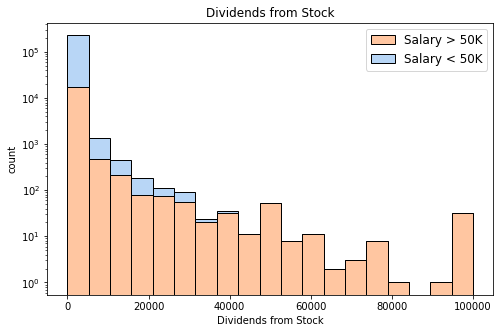

In [212]:
plot_hist(census_income_clean,'DIVVAL','ZA_TARGET','Dividends from Stock','Salary',1)

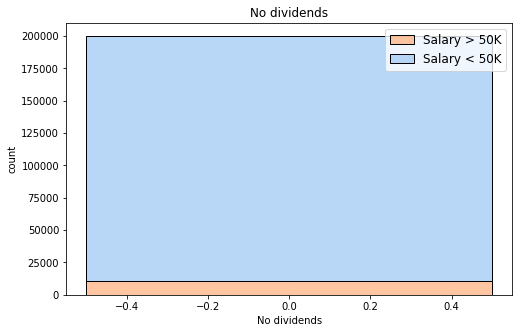

In [213]:
plot_hist(census_income_clean[census_income_clean['DIVVAL']==0],'DIVVAL','ZA_TARGET','No dividends','Salary',0)

Same results as Wage and Capital Gains. Possible Binary candidate.

#### 3f NOEMP (num persons worked for employer)

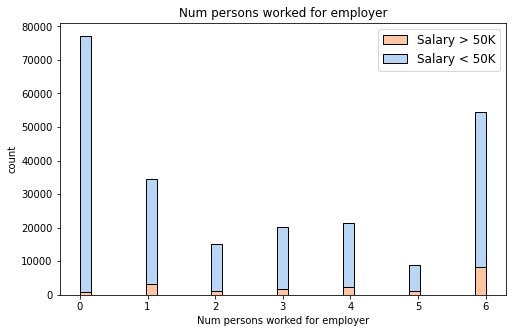

In [214]:
plot_hist(census_income_clean,'NOEMP','ZA_TARGET','Num persons worked for employer','Salary',0)

Very high imbalance, Vast majority with no person working for employer.


#### 3g WKSWORK (weeks worked in year)

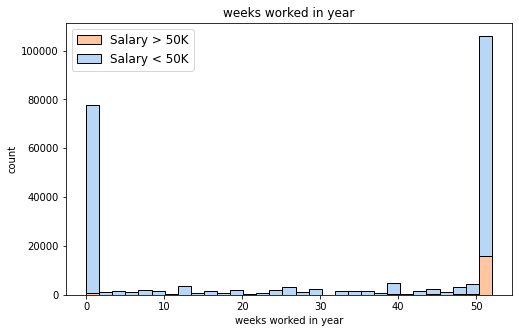

In [215]:
plot_hist(census_income_clean,'WKSWORK','ZA_TARGET','weeks worked in year','Salary',0)

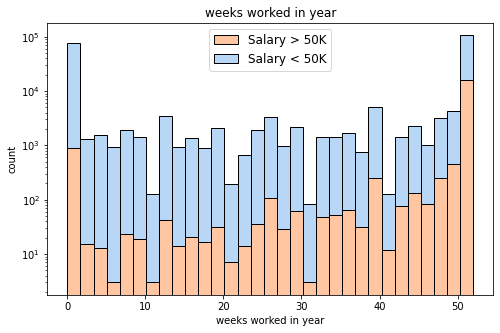

In [216]:
plot_hist(census_income_clean,'WKSWORK','ZA_TARGET','weeks worked in year','Salary',1)

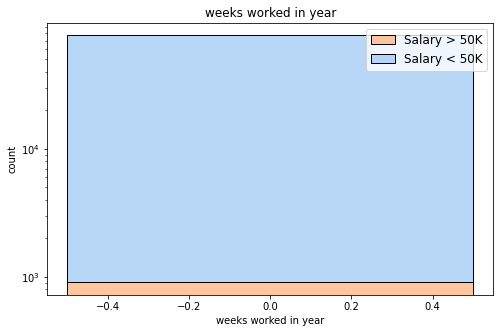

In [217]:
plot_hist(census_income_clean[census_income_clean['WKSWORK']== 0],'WKSWORK','ZA_TARGET','weeks worked in year','Salary',1)

Majority of values at 0 and 52
Consider binning this into 0, 1-51, 52

#### Correlations

In [218]:
# Fill diagonal and upper half with NaNs
corr = census_income_clean.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\AMGra\AppData\Local\Temp\ipykernel_30472\2357974724.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2))


,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,SEOTR,VETYN,WKSWORK,YEAR,ZA_TARGET
AAGE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADTIND,-0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADTOCC,-0.09,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AHRSPAY,-0.01,0.13,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CAPGAIN,0.04,0.05,-0.02,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
CAPLOSS,0.04,0.04,0.01,0.00,-0.02,nan,nan,nan,nan,nan,nan,nan,nan
DIVVAL,0.11,-0.01,-0.05,-0.01,0.12,0.04,nan,nan,nan,nan,nan,nan,nan
NOEMP,-0.07,0.55,0.41,0.16,0.04,0.06,-0.02,nan,nan,nan,nan,nan,nan
SEOTR,-0.10,0.20,0.18,0.04,0.01,0.01,-0.01,0.19,nan,nan,nan,nan,nan
VETYN,0.48,0.34,0.30,0.07,0.03,0.05,0.03,0.32,0.11,nan,nan,nan,nan


NOEMP and WKSWORK show correlation

## 4 Nominal Data

### Text Cleanup and NA inputs

In [219]:
# Check Nominal Columns and convert to lower
col_nominal = list(meta_clean.loc[meta_clean['type'] == 'nominal','name'])

#List of na values
na_list = ['not in universe','?','do not know','na','not in universe under 1 year old','not in universe or children']

# Basic cleaning
# for col in col_nominal:
#     census_income_clean[col] = census_income_clean[col].astype(str) # Convert to String
#     census_income_clean[col] = census_income_clean[col].str.lower() # Convert to lower case
#     census_income_clean[col] = census_income_clean[col].str.strip() # Clean leading/tailing whitspace
#     census_income_clean[col] = census_income_clean[col].apply(lambda x: np.NaN if x in na_list else x).copy()
pd.set_option('mode.chained_assignment', None) 
for col in col_nominal:
    census_income_clean[col] = census_income_clean[col].astype(str) # Convert to String
    census_income_clean[col] = census_income_clean[col].str.lower() # Convert to lower case
    census_income_clean[col] = census_income_clean[col].str.strip() # Clean leading/tailing whitspace
    census_income_clean[col] = census_income_clean[col].apply(lambda x: np.NaN if x in na_list else x)


In [220]:
count = census_income_clean.isna().sum()
missing_df = (pd.concat([count.rename('missing_count'),
                     count.div(len(census_income_clean))
                          .rename('missing_ratio')],axis = 1)
             .loc[count.ne(0)])
missing_df.sort_values('missing_ratio')

print(f'Number of complete features: {len(col_nominal)-len(missing_df)}')
print(f'Number of incomplete features: {len(missing_df)}')

,missing_count,missing_ratio
AREORGN,1672,0.007214
PENATVTY,5057,0.021820
PEMNTVTY,8779,0.037880
PEFNTVTY,9690,0.041810
ACLSWKR,83508,0.360321
AMJIND,84080,0.362789
AMJOCC,84080,0.362789
MIGSAME,114346,0.493381
MIGMTR4,114346,0.493381
MIGMTR3,114346,0.493381


Number of complete features: 14
Number of incomplete features: 19


We have 14 Complete features and 19 Incomplete feature with NA

## 4a Incomplete Features

Feature will be checked for MCAR by using a chi-squared test and Cramers Coeffcients

In [221]:
import missingno as msno


<AxesSubplot:>

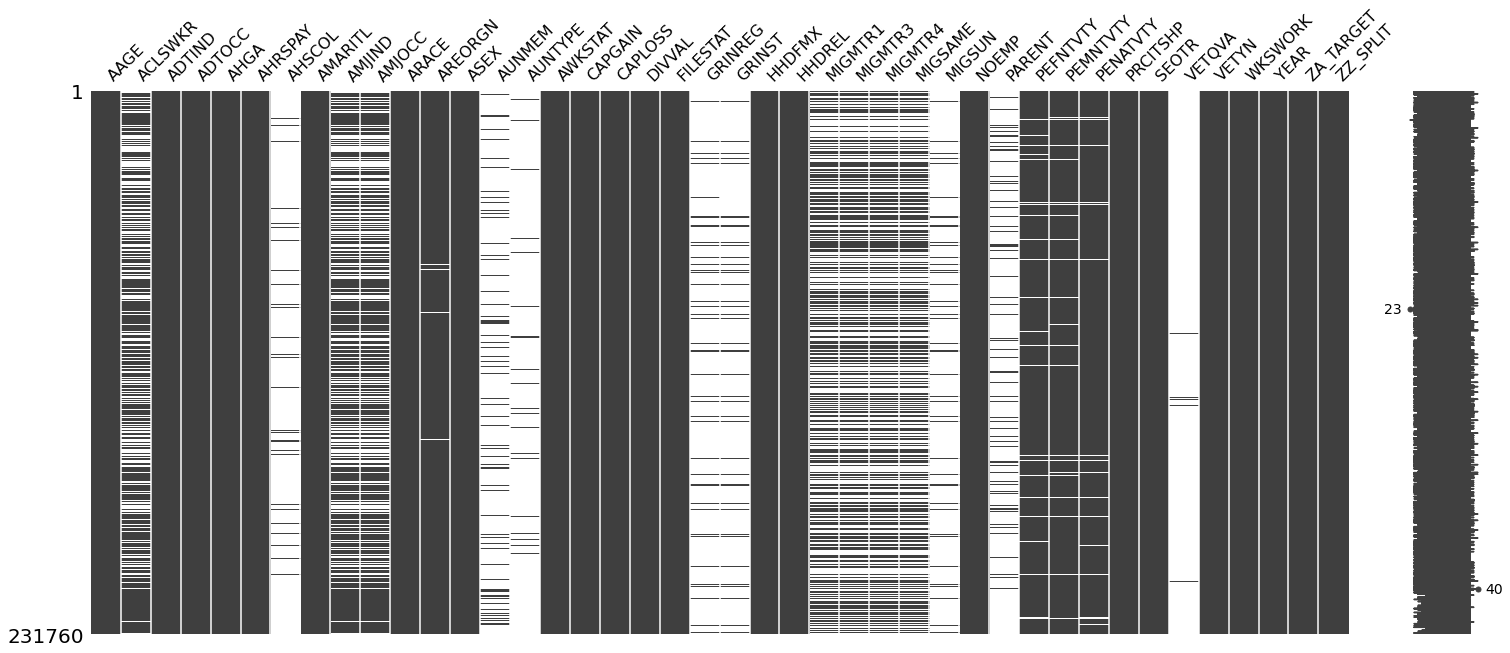

In [222]:
msno.matrix(census_income_clean.sort_values(by='ZA_TARGET'))

<AxesSubplot:>

<AxesSubplot:>

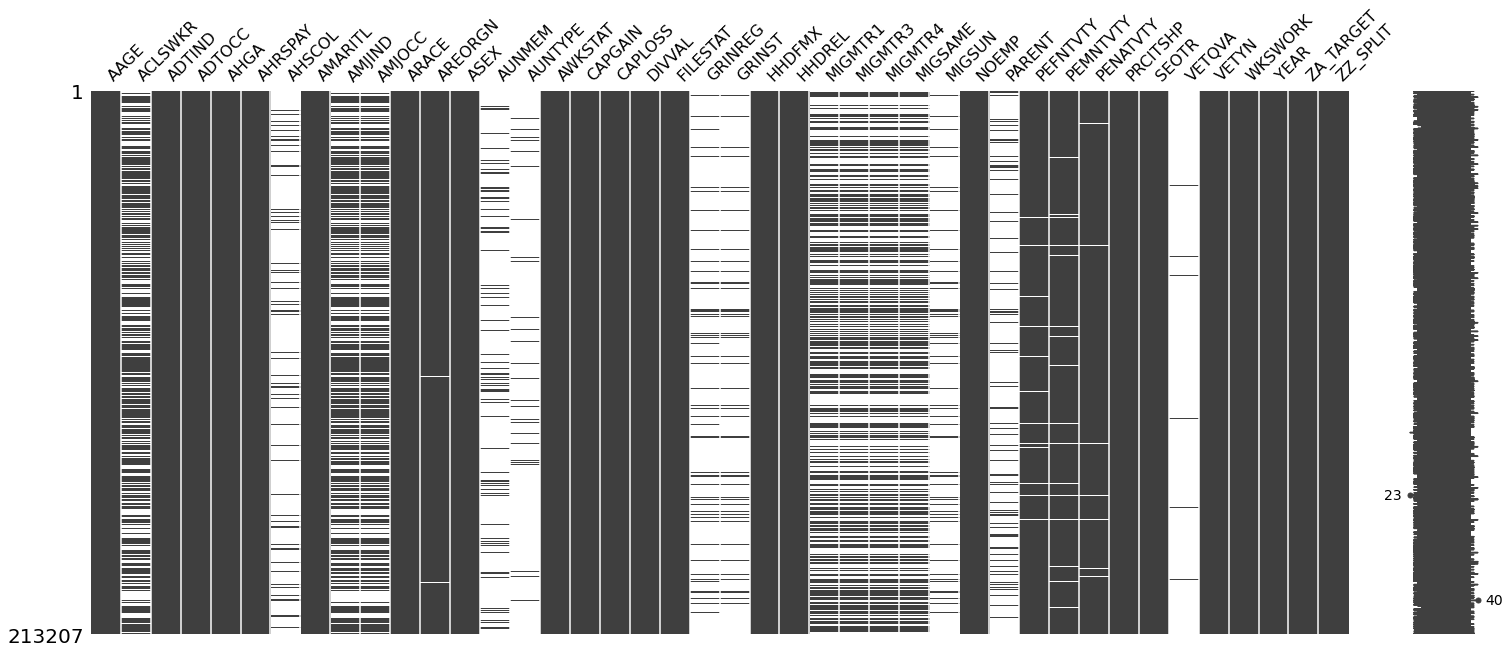

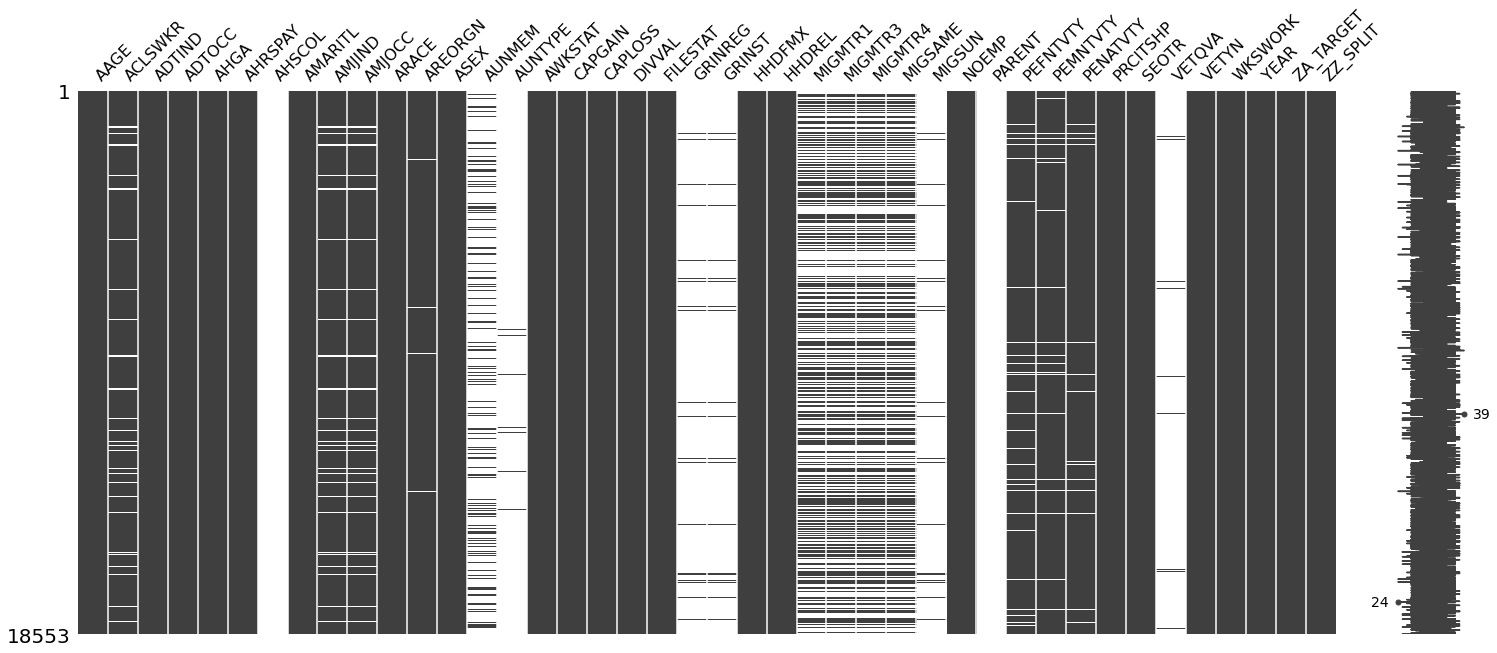

In [223]:
msno.matrix(census_income_clean[census_income_clean['ZA_TARGET'] == 0])
msno.matrix(census_income_clean[census_income_clean['ZA_TARGET'] == 1])

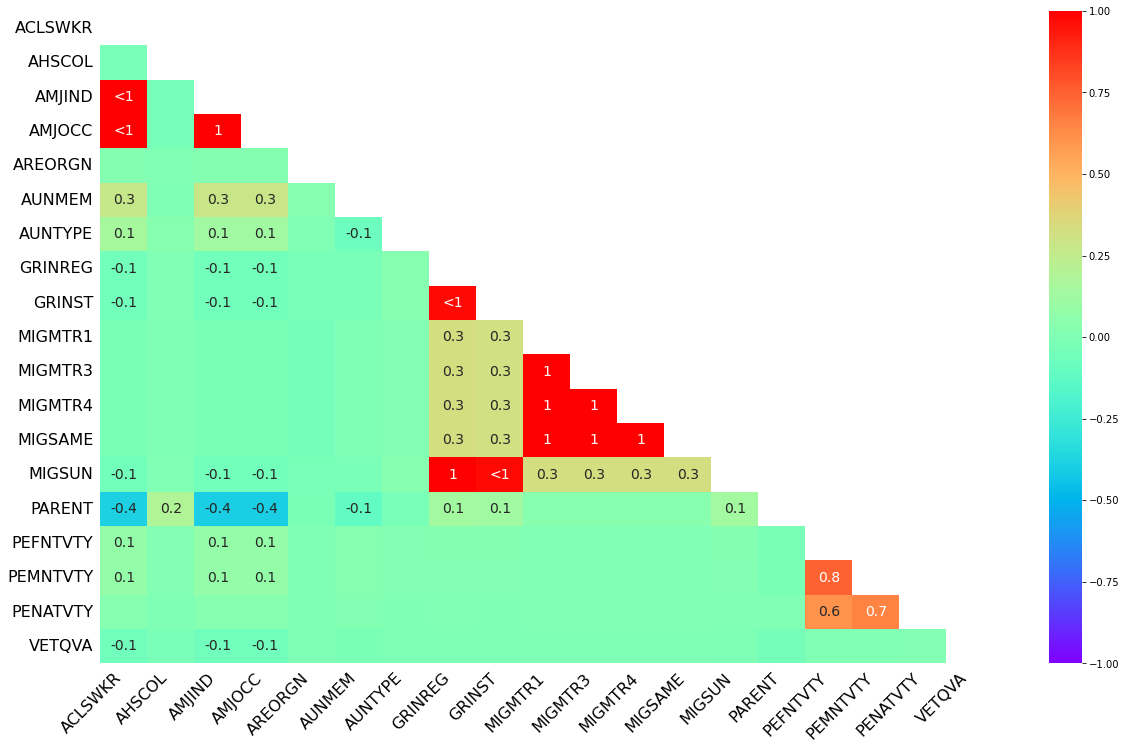

In [224]:
msno.heatmap(census_income_clean, cmap='rainbow');

From this we see thatMost Columns look to be MCAR/MAR with the following exceptions...
-AMJOCC and ACLSWKR (Class of Worker and Major Occupation Code)
This makes sense as they seem to be referencing the same thing
-GRINREG and GRINST (region and state of previous residence) 
This makes sense as one is depedent of the other.
-MIGMTR1,MIGMTR3,MIGMTR4 (Migration code Data)
-PEFNTVTY and PEMNTVTY (Birth pace of Parents)

From this, the fact that the missingness looks to be random,  using a threshold of 30%.  The follwing features should be considered to be dropped:

- AMJIND	84080	0.362789 
- ACLSWKR	83508	0.360321
- AMJOCC	84080	0.362789
- MIGSAME	114346	0.493381
- MIGMTR4	114346	0.493381
- MIGMTR3	114346	0.493381
- MIGMTR1	114346	0.493381
- AUNMEM	203225	0.876877
- PARENT	203808	0.879392
- GRINREG	208751	0.900721
- MIGSUN	208751	0.900721
- GRINST	209776	0.905143
- AHSCOL	215546	0.930040
- AUNTYPE	222633	0.960619
- VETQVA	228779	0.987138

With the following to be kept:
- AREORGN	    1672	0.007214
- PENATVTY	5057	0.021820
- PEMNTVTY	8779	0.037880
- PEFNTVTY	9690	0.041810


In [225]:
# Update Meta Table
meta_clean.reset_index(drop=True)
col_to_drop = missing_df[missing_df['missing_ratio']>.3].index.to_list()
meta_clean['Drop'] =  meta_clean['name'].apply(lambda x: 1 if x in col_to_drop else 0)


,name,num_uniq,type,long_name_t1
0,AAGE,91,continuous,age
1,ACLSWKR,9,nominal,class of worker
2,ADTIND,52,nominal,industry code
3,ADTOCC,47,nominal,occupation code
4,AHGA,17,nominal,education
5,AHRSPAY,1240,continuous,wage per hour
6,AHSCOL,3,nominal,enrolled in edu inst last wk
7,AMARITL,7,nominal,marital status
8,AMJIND,24,nominal,major industry code
9,AMJOCC,15,nominal,major occupation code


Next, let's see if the remaining NA's constitute a significant remaining portion of the data.

In [226]:
old = census_income_clean.shape
census_income_clean= census_income_clean.drop(columns = col_to_drop)
census_income_clean = census_income_clean.dropna()
new = census_income_clean.shape

print(f'NA porortion dropped: {(old[0] -new[0])/old[0]}')


NA porortion dropped: 0.058659820503969624


Total Data loss is 6.8% from delteling rows with NAs.  Each feature has less than 5% of records being deleted. This is acceptable.

In [227]:
census_income.groupby('ADTIND')['ZA_TARGET'].value_counts().unstack().sort_values(by=[0],ascending=False)
#.unstack().sort_values(by='0')

ZA_TARGET,0,1
ADTIND,,
0,149616.0,1351.0
33,24612.0,1170.0
43,11140.0,1370.0
4,8232.0,819.0
42,6104.0,883.0
29,5680.0,740.0
37,5387.0,774.0
45,5113.0,1573.0
41,5103.0,712.0


#### 4b Feature exploration

In [228]:
meta_clean[(meta_clean['type'] == 'nominal') & (meta_clean['Drop'] == 0)][['name','long_name_t1']]


,name,long_name_t1
2,ADTIND,industry code
3,ADTOCC,occupation code
4,AHGA,education
7,AMARITL,marital status
10,ARACE,mace
11,AREORGN,hispanic Origin
12,ASEX,sex
15,AWKSTAT,full or part time employment stat
19,FILESTAT,tax filer status
22,HHDFMX,detailed household and family stat


- ADTIND	industry code
   Leave as is. Majority are 0

- ADTOCC	occupation code
    Leave as is. Majority are 0

- AHGA	education
    Group under 1tth grade, reclassify as Ordinal

- AMARITL	marital status
    Leave as is.

- ARACE	race
    Leave as is.

- AREORGN	hispanic Origin
    Bin into Hispanic/ Not Hispanic

- ASEX	sex
    Change to binary. Note that Males are overrepresented in salary >50k

- AWKSTAT	full or part time employment stat
    Consolodate all values relating to unemployed in one category

- FILESTAT	tax filer status
    Leave as is.

- HHDFMX	detailed household and family stat
    Consolidate all categories except for householder, spouse of householder, nonfamily householder, secondary individual.
    Consider removing for HHDREL

- HHDREL	detailed household summary in household
    Consolidate all non householder categories

- PEFNTVTY	country of birth father
    As is, or possible USA and non-USA if performance is an issue

- PEMNTVTY	country of birth mother
    As is, or possible USA and non-USA if performance is an issue

- PENATVTY	country of birth self
    As is, or possible USA and non-USA if performance is an issue

- PRCITSHP	citizenship
    Leave as is

- SEOTR	own business or self employed

- VETYN	veterans benefits
    Leave As is

- YEAR	NaN
    Consider Removing, seems to be informational to when data was collected

In [229]:
def plot_cat(data,x,xlabel):


    df  = data.groupby(x)['ZA_TARGET'].value_counts().unstack().sort_values(by=[1],ascending=False)

    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (24,6))
    ax1.bar(df.index, df[0], label = "Salary < 50K") 
    ax1.bar(df.index, df[1], bottom = df[0], label = "Salary > 50K") 

    title = f'{x} {xlabel}'
    ax1.set_title(title)
    ax1.set_ylabel('count')
    ax1.tick_params(axis='x', labelrotation = 80)

    ax1.legend(('Salary < 50K', 'Salary > 50K'), fontsize=12)

    ax2.bar(df.index, df[0], label = "Salary < 50K") 
    ax2.bar(df.index, df[1], bottom = df[0], label = "Salary > 50K") 

    title = f'{x} {xlabel} (log)'
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.set_ylabel('count')
    ax2.tick_params(axis='x', labelrotation = 80)

    ax2.legend(('Salary < 50K', 'Salary > 50K'), fontsize=12)


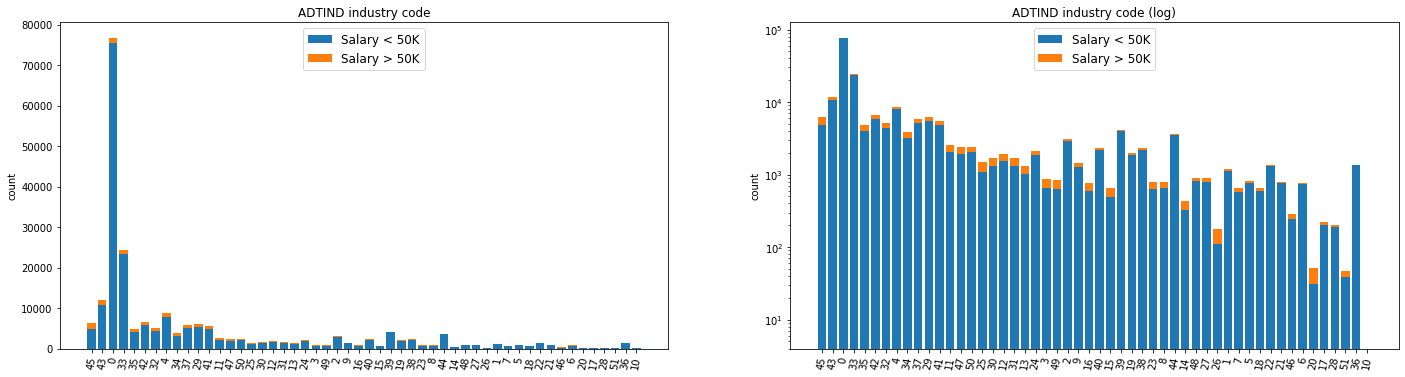

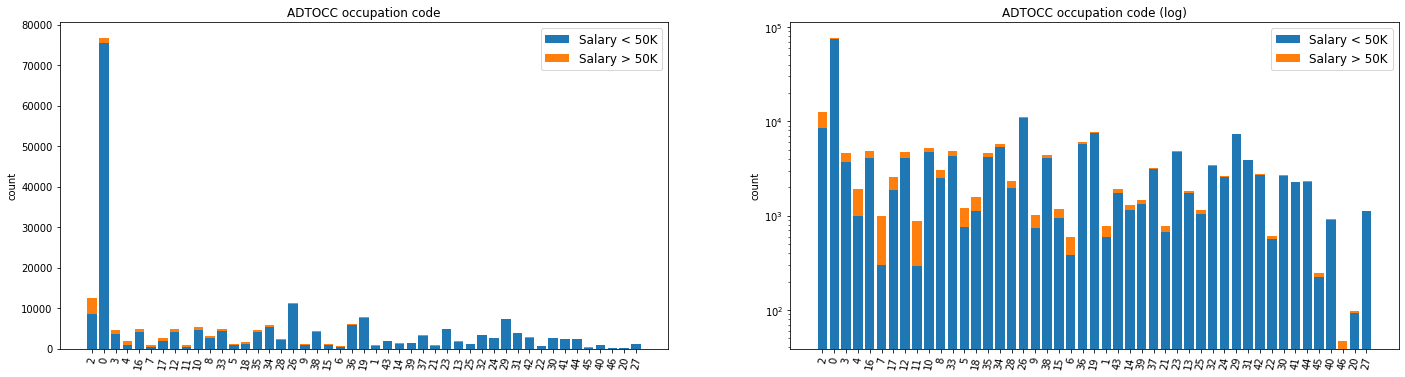

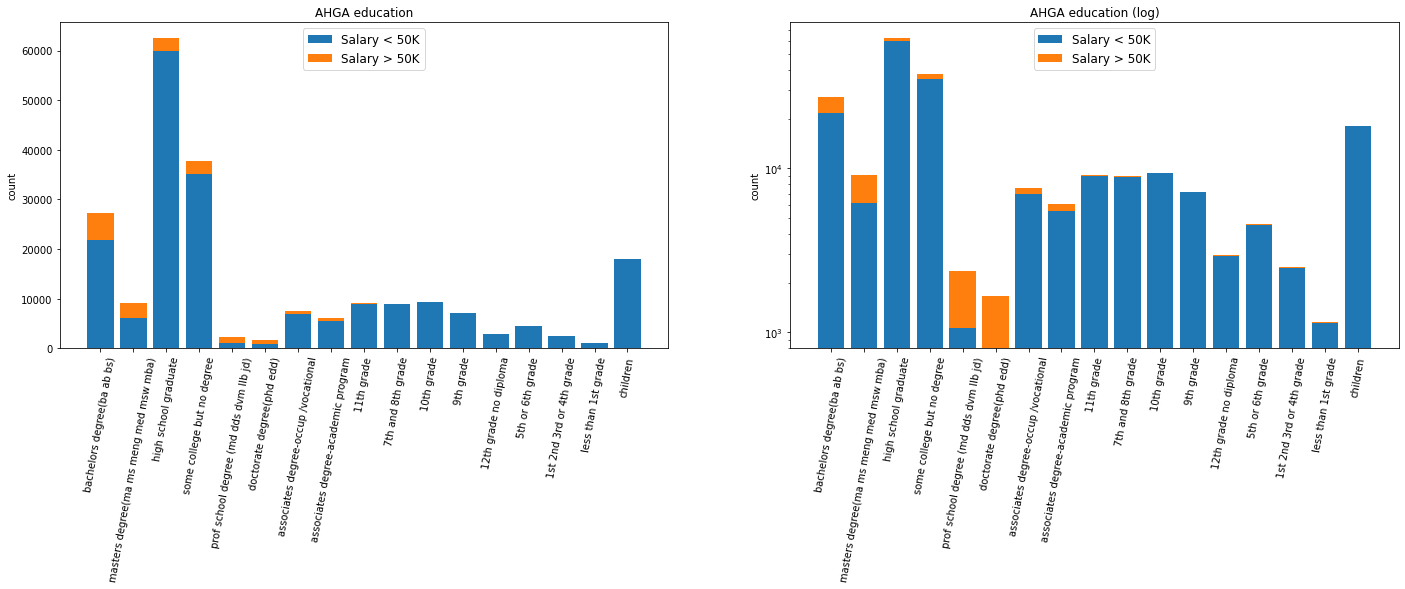

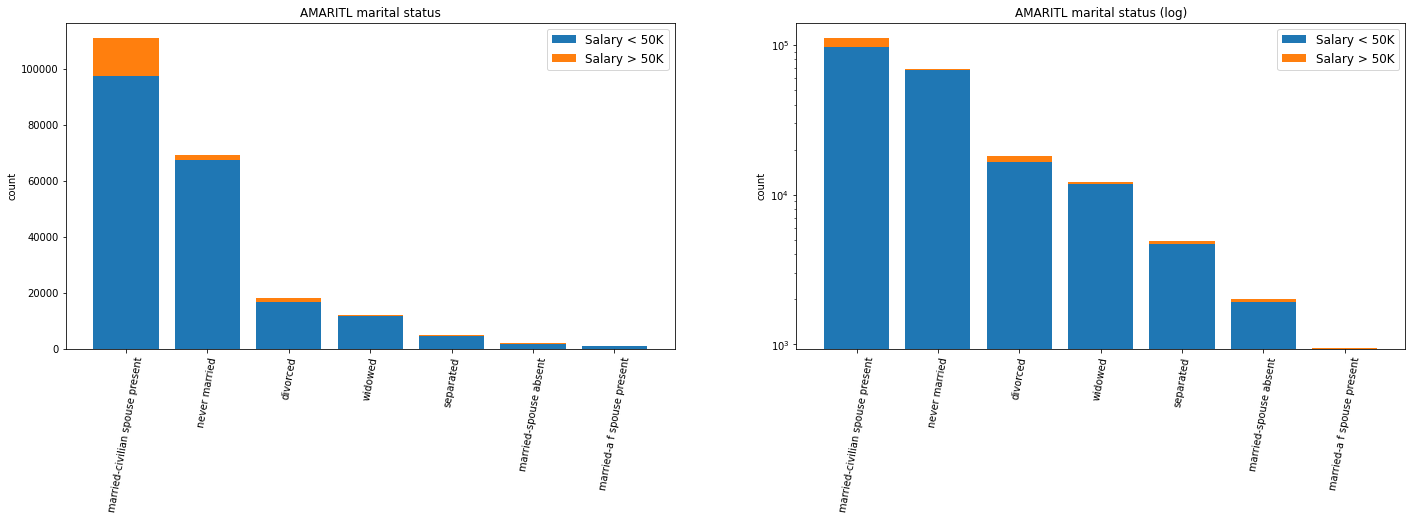

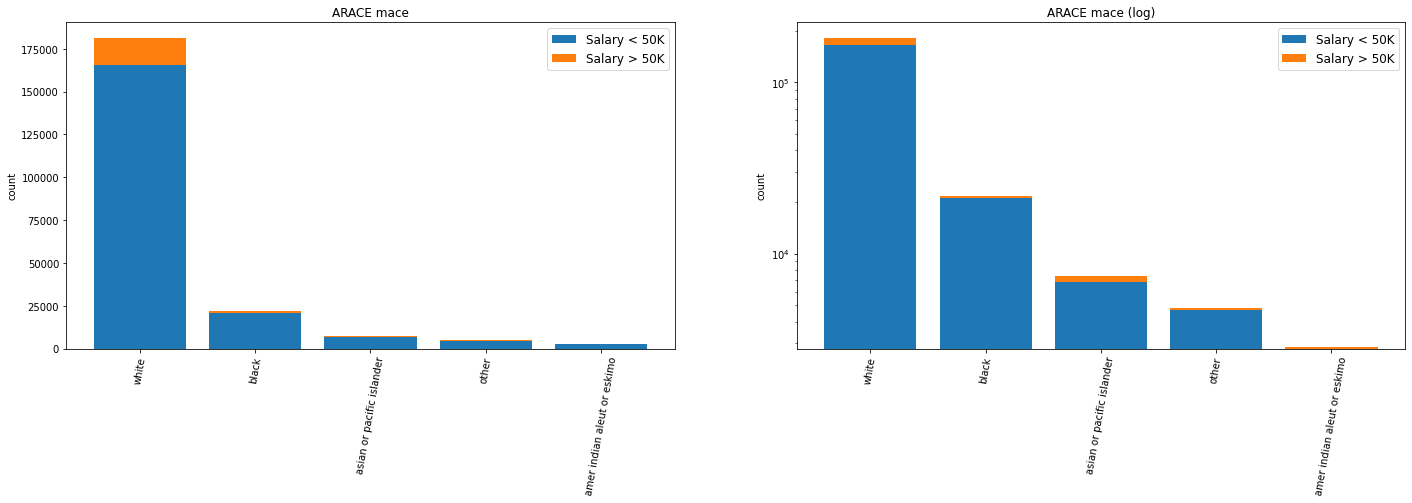

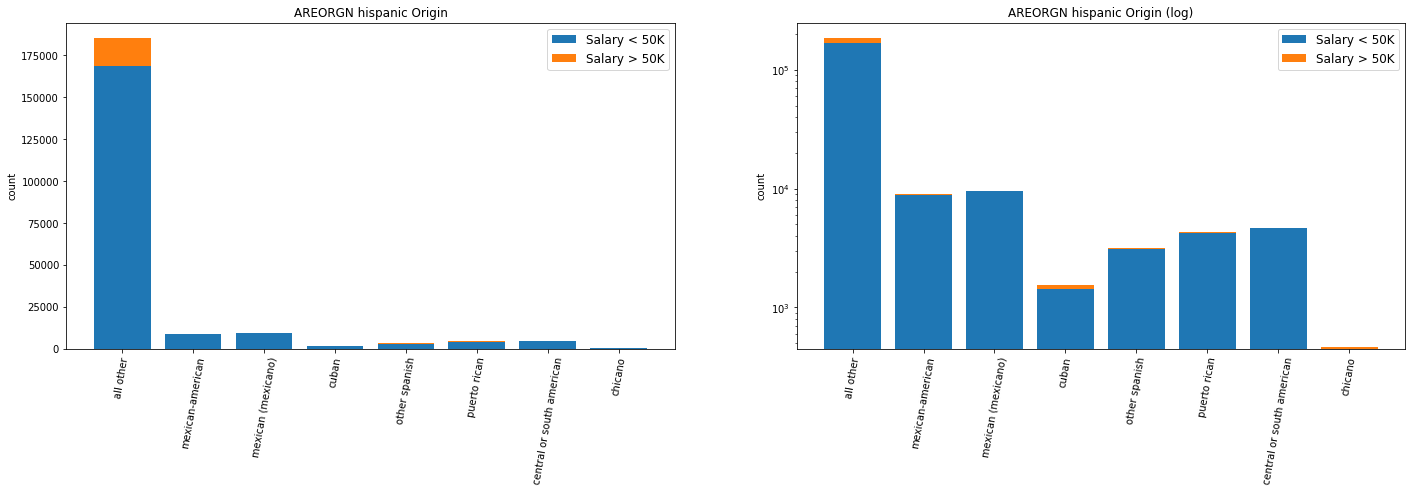

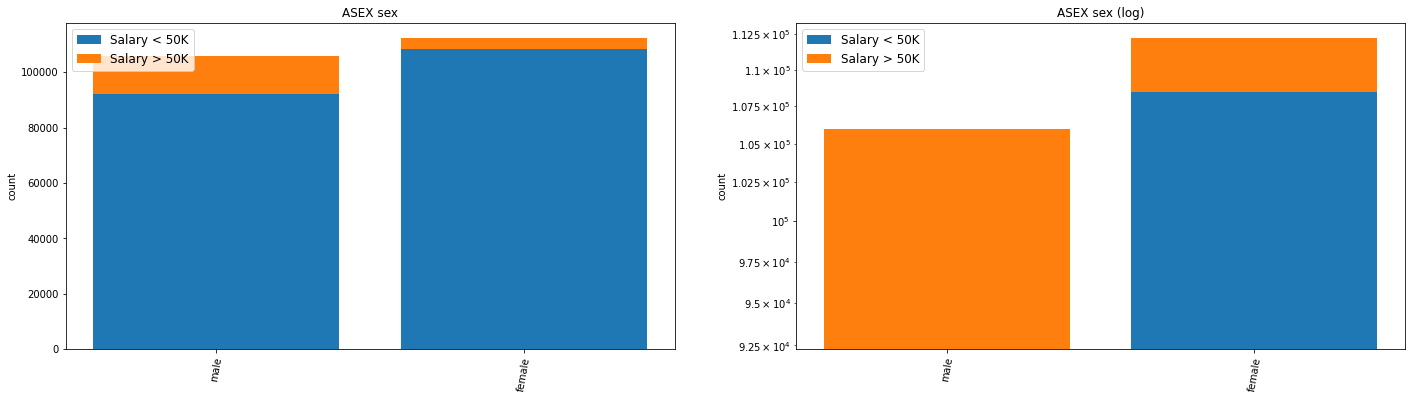

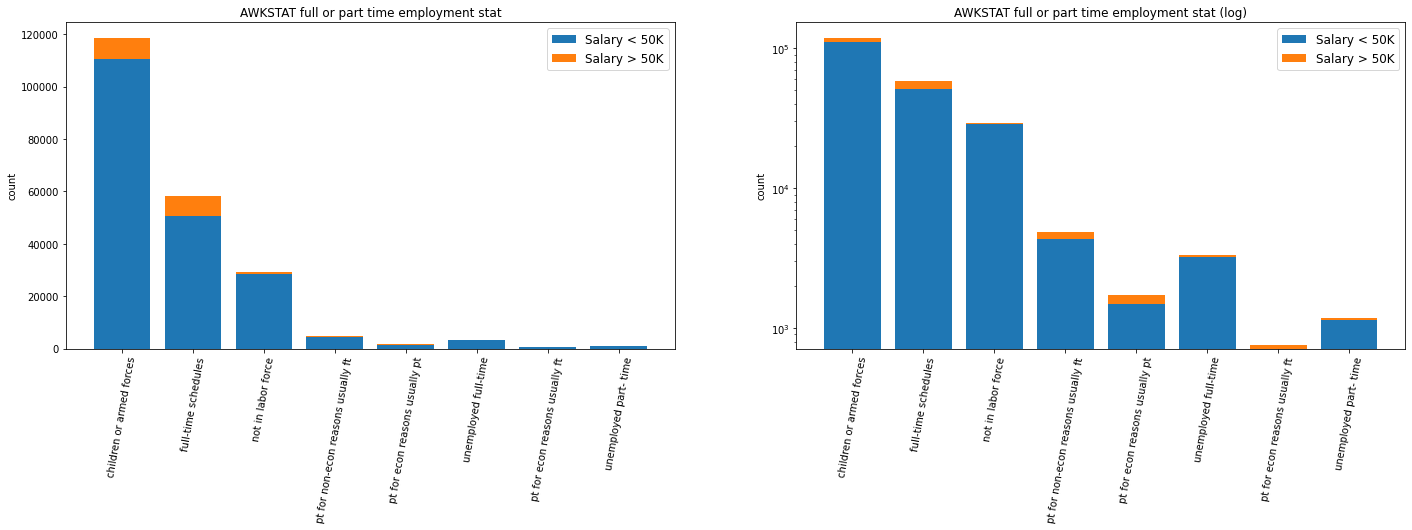

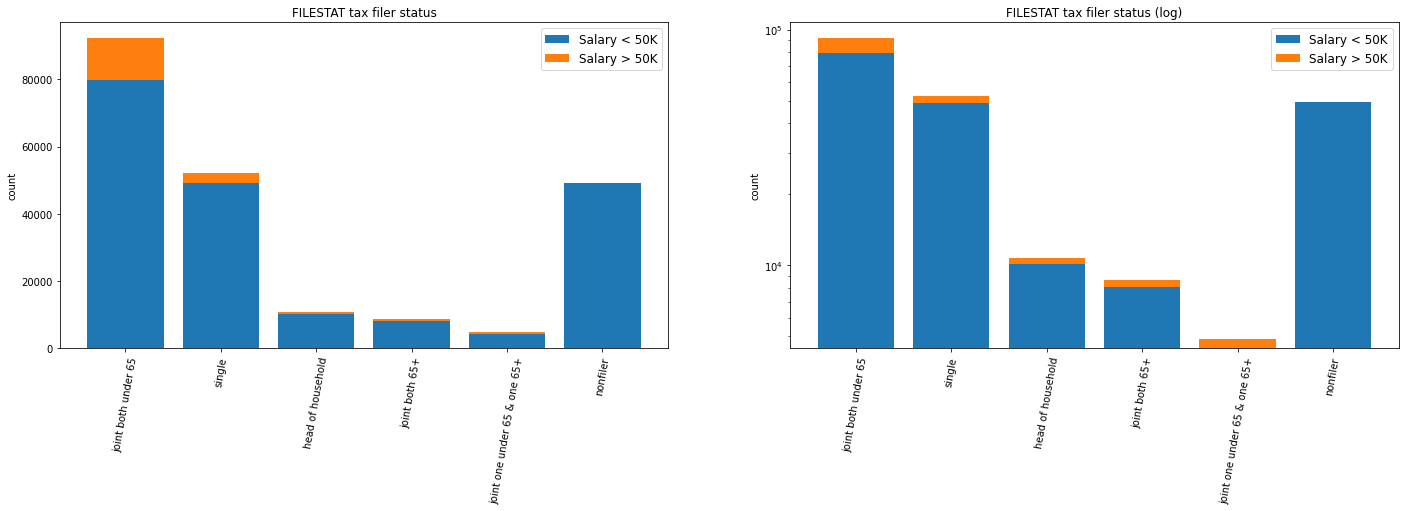

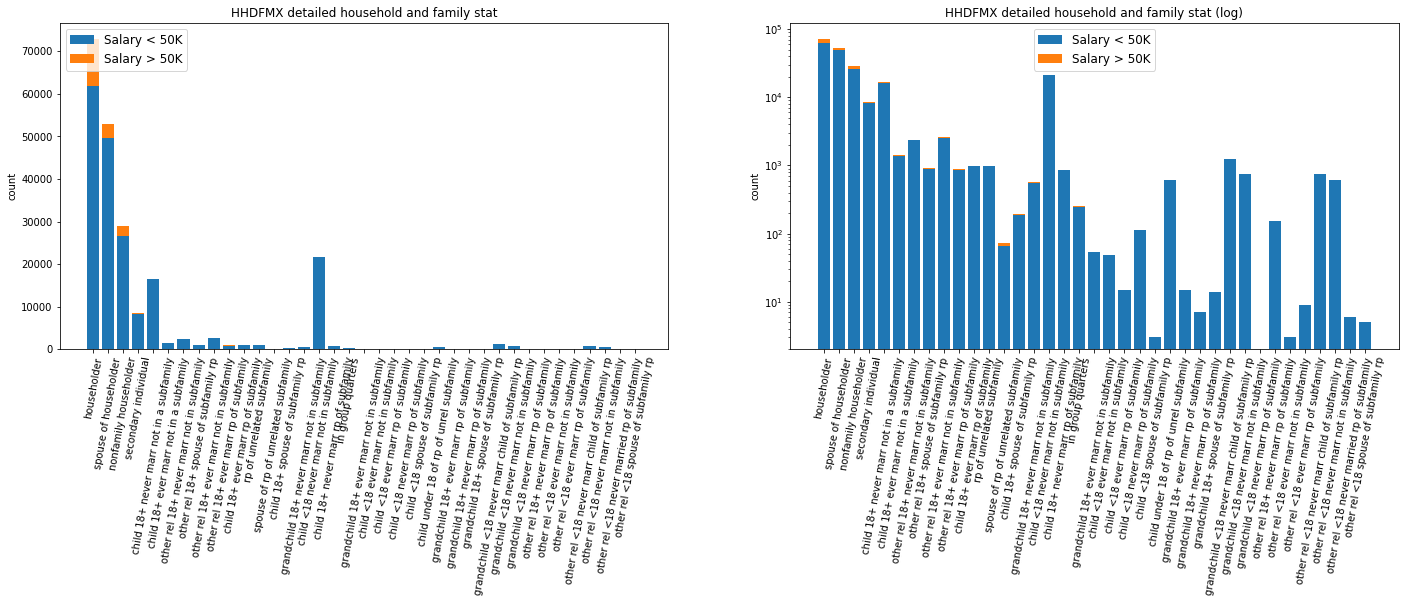

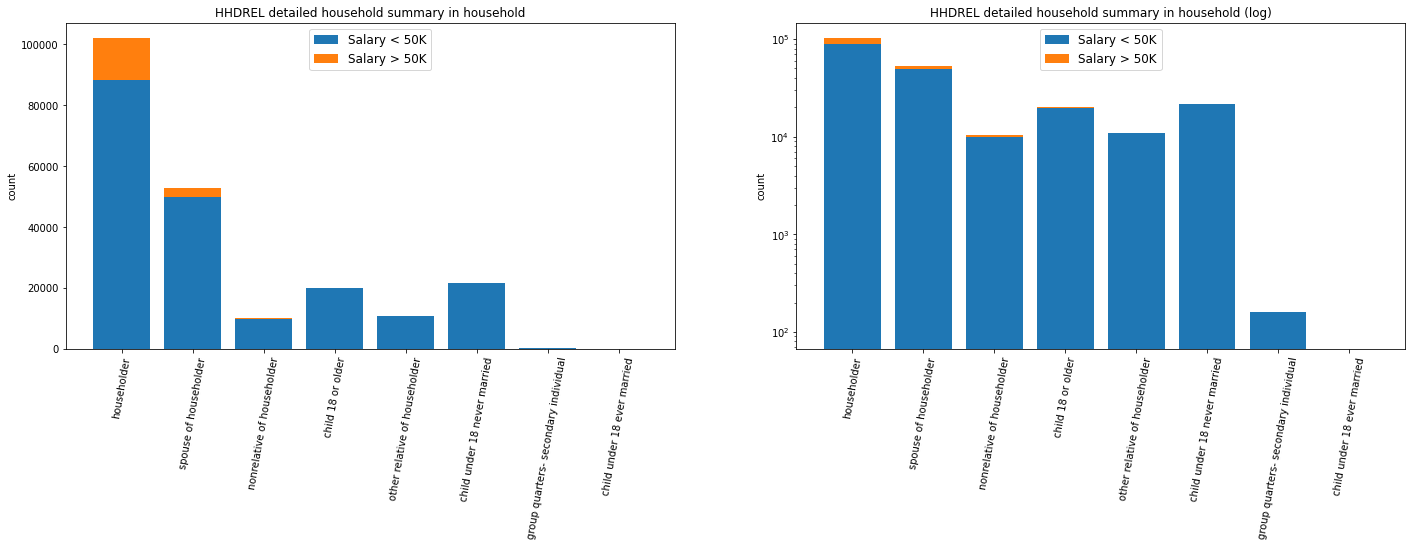

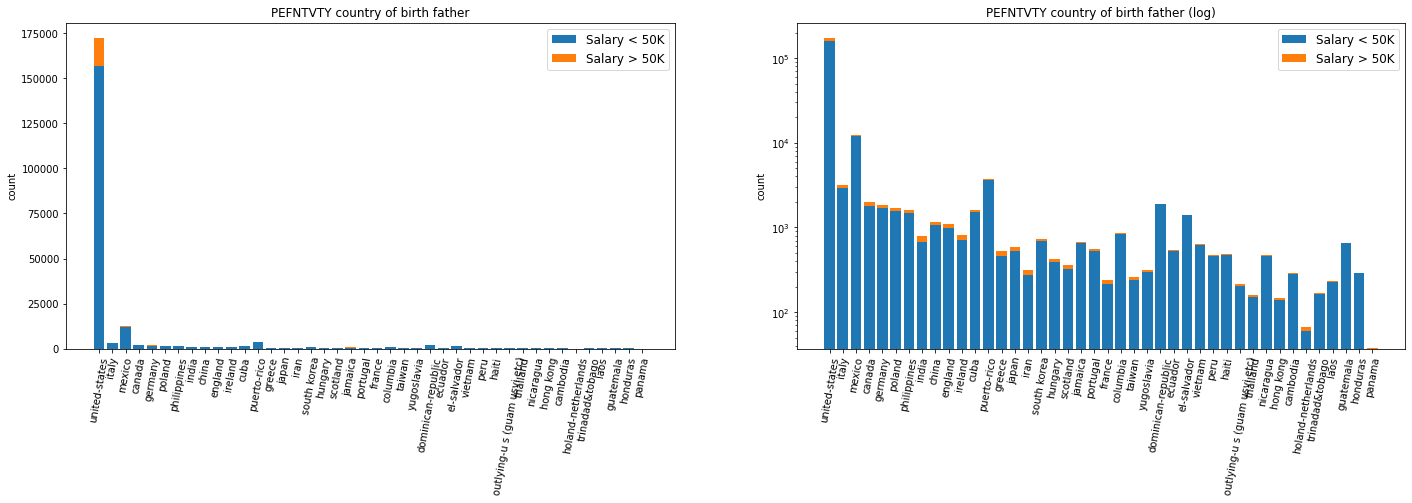

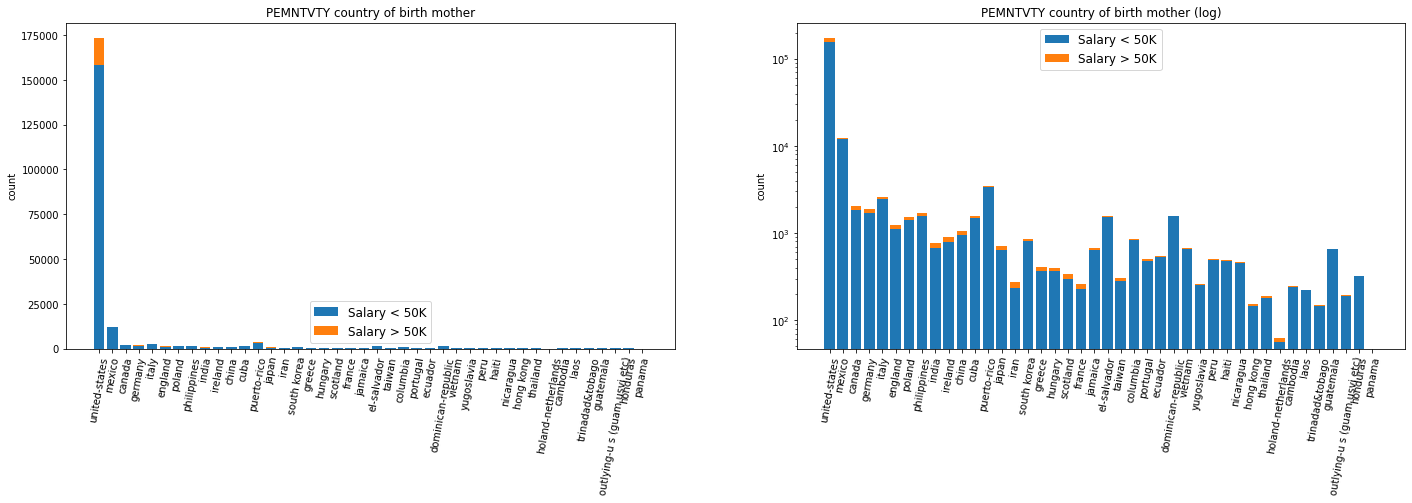

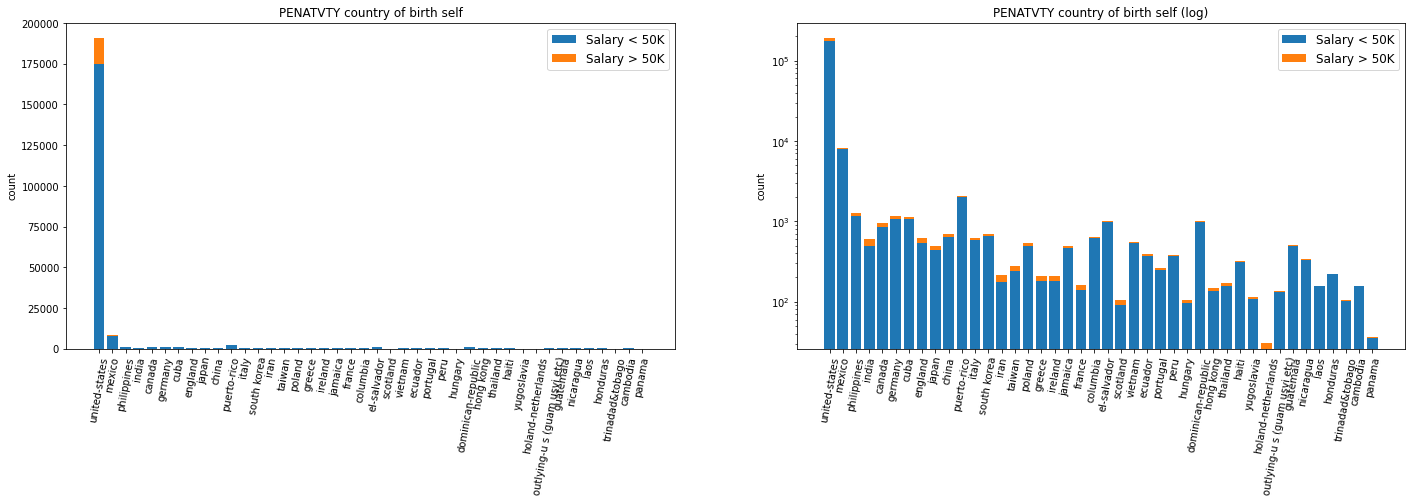

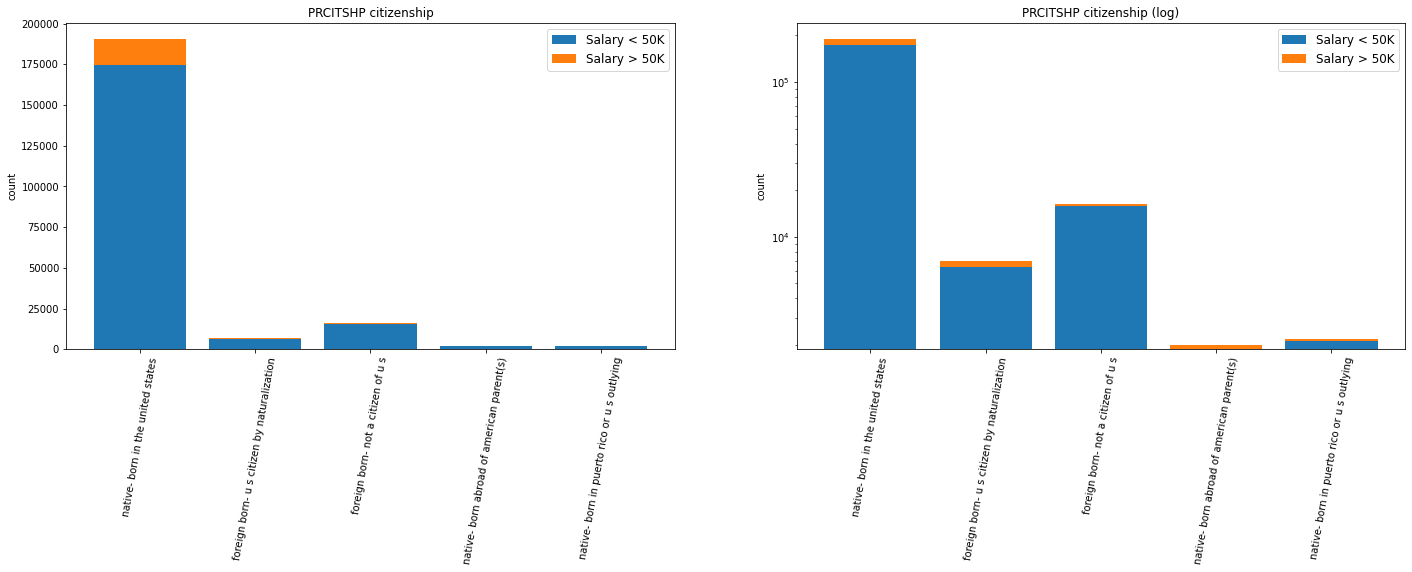

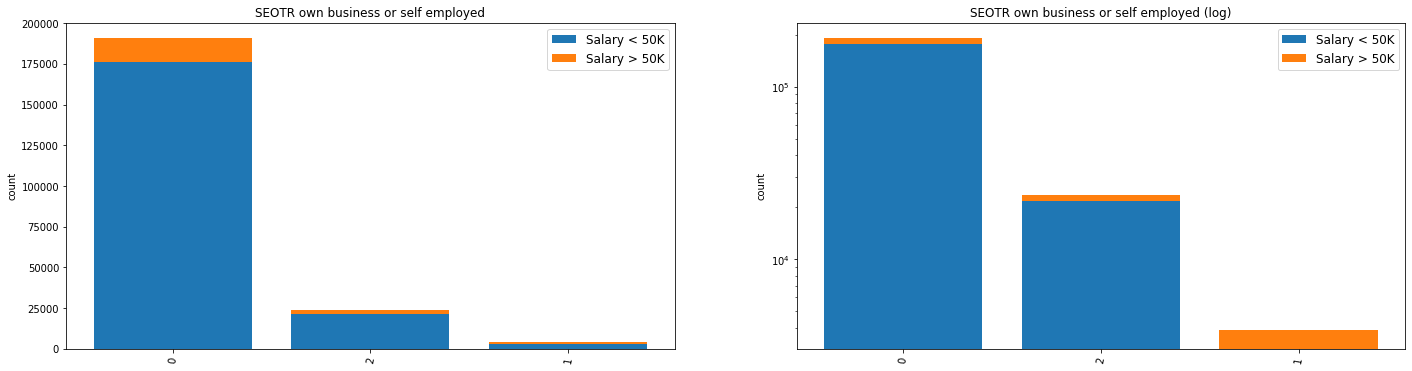

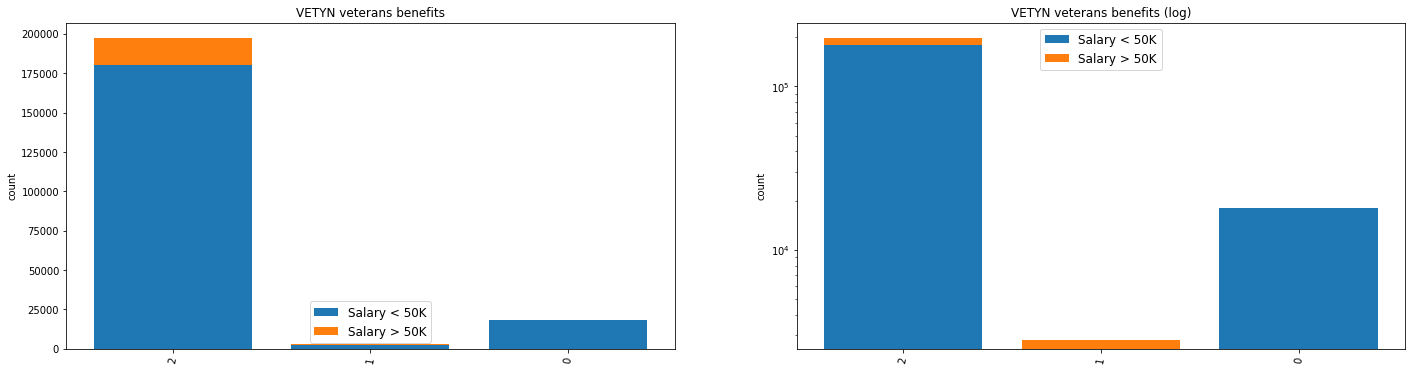

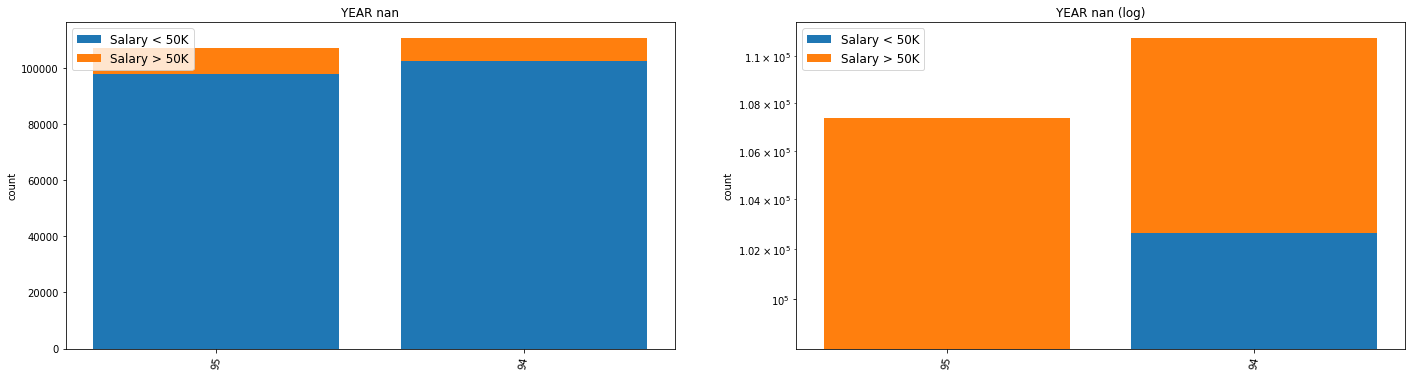

In [230]:
nom = meta_clean[(meta_clean['type']=='nominal') & (meta_clean['Drop'] ==0)]

names = list(nom['name'])
descriptions = list(nom['long_name_t1'])
for i, name in enumerate(names): 
    plot_cat(census_income_clean,name,descriptions[i])



-ADTIND
-ADTOCC
-AHGA
-AMARITL
-AMJIND
-ARACE
-AREORGN
-ASEX
-AWKSTAT
-FILESTAT
-HHDFMX
-HHDREL
-PEFNTVTY
-PEMNTVTY
-PENATVTY
-PRCITSHP
-SEOTR
-VETYN
-YEAR

In [231]:
print(meta_clean[(meta_clean['Drop']==0)&(meta_clean['type']=='nominal')]['name'])

2       ADTIND
3       ADTOCC
4         AHGA
7      AMARITL
10       ARACE
11     AREORGN
12        ASEX
15     AWKSTAT
19    FILESTAT
22      HHDFMX
23      HHDREL
31    PEFNTVTY
32    PEMNTVTY
33    PENATVTY
34    PRCITSHP
35       SEOTR
37       VETYN
39        YEAR
Name: name, dtype: object


### Checking that the Test and Train set are balanced

In [232]:
# Using the Kolmogorov-Smirnov distance the distance for a variable between two data sets will be used
from scipy import stats

X_train = census_income_train.iloc[: , :-2] # drop target and split ref
X_test = census_income_test.iloc[: , :-2] # drop target and split ref
distances1 = list(map(lambda i : stats.ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(X_train.shape[1])))


print(f"Maximum distance before cleaning: {max(distances1)}")

X_train = census_income_clean[census_income_clean['ZZ_SPLIT'] == 'train'].drop(columns=['ZA_TARGET','ZZ_SPLIT']) # drop target and split ref
X_test = census_income_clean[census_income_clean['ZZ_SPLIT'] == 'test'].drop(columns=['ZA_TARGET','ZZ_SPLIT']) # drop target and split ref
distances2 = list(map(lambda i : stats.ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(X_train.shape[1])))
print(f"Maximum distance after cleaning: {max(distances2)}")

Maximum distance before cleaning: 0.0042192991102528166
Maximum distance after cleaning: 0.01840172500672793


Test and Train splits are balanced and wwere not significantly affected by the cleaning efforts

#### Checking the Balance of Target

<AxesSubplot:xlabel='ZA_TARGET', ylabel='Count'>

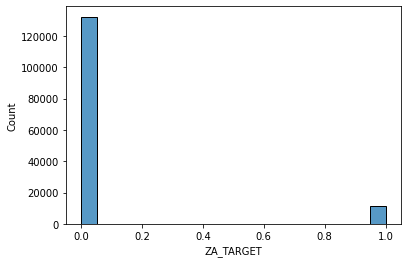

In [233]:
sns.histplot(census_income_clean[census_income_clean['ZZ_SPLIT']=='train'],x = 'ZA_TARGET')

The target variable is highly unbalanced, and this will have to be considered for model creation.


## Feature Engineering

In [234]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

In [235]:
census_income_clean.columns

Index(['AAGE', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AMARITL', 'ARACE',
       'AREORGN', 'ASEX', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL',
       'FILESTAT', 'HHDFMX', 'HHDREL', 'NOEMP', 'PEFNTVTY', 'PEMNTVTY',
       'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETYN', 'WKSWORK', 'YEAR',
       'ZA_TARGET', 'ZZ_SPLIT'],
      dtype='object')

> No Change

In [236]:
# Continuous

# AAGE
# AHRSPAY
# NOEMP

In [237]:
# Not sure
# ADTIND
# ADTOCC

> Create Dummies

In [238]:
# HHDFMX

keep = ['householder','spouse of householder','nonfamily householder','secondary individual']

census_income_clean['HHDFMX'] = census_income_clean['HHDFMX'].apply(lambda x: x if x in keep else 'other')

In [239]:
#HHDREL
keep = ['householder','spouse of householder']

census_income_clean['HHDREL'] = census_income_clean['HHDREL'].apply(lambda x: x if x in keep else 'other')

In [240]:
# Create Dummy
cat = ['AMARITL',
        'ARACE',
        'ASEX',
        'AWKSTAT',
        'FILESTAT',
        'SEOTR',
        'VETYN',
        'YEAR',
        'AREORGN',
        'HHDFMX',
        'HHDREL',
        'PRCITSHP']

census_income_clean = pd.get_dummies(census_income_clean, columns=cat)



> Converting to Ordinal

In [241]:
#PEFNTVTY
census_income_clean['PEFNTVTY'] = census_income_clean['PEFNTVTY'].apply(lambda x: 1 if x == 'united-states' else 0)

In [242]:
#PEMNTVTY
census_income_clean['PEMNTVTY'] = census_income_clean['PEMNTVTY'].apply(lambda x: 1 if x == 'united-states' else 0)

In [243]:
#PENATVTY
census_income_clean['PENATVTY'] = census_income_clean['PENATVTY'].apply(lambda x: 1 if x == 'united-states' else 0)

In [244]:
#CAPGAIN
census_income_clean['CAPGAIN'] = census_income_clean['CAPGAIN'].apply(lambda x: 0 if x == 0 else 1)

In [245]:
# CAPLOSS
census_income_clean['CAPLOSS'] = census_income_clean['CAPLOSS'].apply(lambda x: 0 if x == 0 else 1)

In [246]:
#DIVVAL
census_income_clean['DIVVAL'] = census_income_clean['DIVVAL'].apply(lambda x: 0 if x == 0 else 1)

In [247]:
# WKSWORK
def wksworksplit(x):
    if x == 0:
        return 0
    elif x < 52:
        return 1
    else: 
        return 2

census_income_clean['WKSWORK'] = census_income_clean['WKSWORK'].apply(lambda x: wksworksplit(x))

In [248]:
# AHGA
edu_tran = {'children':0,
            'less than 1st grade':1,
            '1st 2nd 3rd or 4th grade':2,
            '5th or 6th grade':3,
            '7th and 8th grade':4,
            '9th grade':5,
            '10th grade':6,
            '11th grade':7,
            '12th grade no diploma':8,
            'high school graduate':9,
            'some college but no degree':10,
            'associates degree-occup /vocational':11,
            'associates degree-academic program':12,
            'bachelors degree(ba ab bs)':13,
            'masters degree(ma ms meng med msw mba)':14,
            'prof school degree (md dds dvm llb jd)':15,
            'doctorate degree(phd edd)':16
}

census_income_clean['AHGA'] = census_income_clean['AHGA'].apply(lambda x: edu_tran[x])

### Save file

In [249]:
census_income_clean.to_csv('census_clean.csv',index=False)